## Homework 01. Simple text processing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

from collections import Counter

%matplotlib inline
sns.set_style("dark")

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

*Disclaimer: The used dataset may contain obscene language and is used only as an example of real unfiltered data.*

In [2]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [3]:
# try:
#     data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
# except FileNotFoundError:
#     ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
#     data = pd.read_csv("comments.tsv", sep='\t')

In [2]:
url = "https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv"
data = pd.read_csv(url, sep='\t')

In [3]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [4]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [6]:
# task: preprocess each comment in train and test

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

In [7]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [8]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))
bow_vocabulary = [token[0] for token in Counter(' '.join(texts_train).split()).most_common()[:k]]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [11]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    token_to_count = Counter(text.split())
    array = [token_to_count[token] for token in bow_vocabulary]

    return np.array(array, 'float32')

In [12]:
class SelfMadeBOW:
    def __init__(self, corpus: list, vocab_size=10000):
        self._vocab_size = min(vocab_size, len(set(' '.join(corpus).split())))
        self._vocab = [token[0] for token in Counter(' '.join(corpus).split()).most_common()[:self._vocab_size]]
    
    def _text_features(self, text):
        token_to_count = Counter(text.split())
        array = [token_to_count[token] for token in self._vocab]
        return np.array(array, 'float32')
    
    def extract(self, texts):
        return np.stack(list(map(self._text_features, texts)))

In [13]:
bow = SelfMadeBOW(texts_train)
bow_vocab_size = bow._vocab_size

X_train_bow = bow.extract(texts_train)
X_test_bow =  bow.extract(texts_test)

In [14]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [15]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

NameError: name 'X_train_bow' is not defined

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [19]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [20]:
from utils import plot_train_process

In [19]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(in_features=bow_vocab_size, out_features=2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [20]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

In [21]:
X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Let's test that everything is fine

In [22]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [23]:
def train_model(
    model,
    opt,
    loss_function,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    show_final_plot=False,
    eval_every=10,
    title_suffix=''
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history, title_suffix=title_suffix)
    if show_final_plot:
        plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history, title_suffix=title_suffix)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

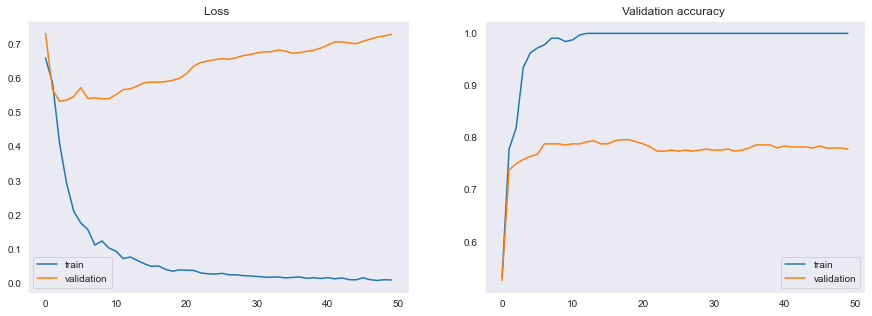

In [24]:
train_model(model, opt, loss_function, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch);

In [25]:
def evaluate_torch_model(model, X_train, y_train, X_test, y_test, title):
    for name, X, y in [
        ('train', X_train, y_train),
        ('test ', X_test, y_test)
    ]:
        proba = model(X).detach().cpu().numpy()[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))
    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.title(title)
    plt.legend(fontsize='large')
    plt.grid()
    plt.show()

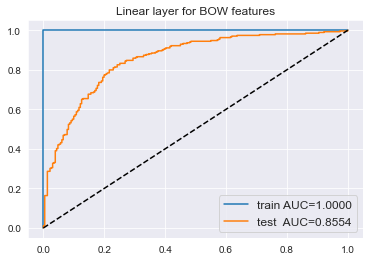

In [26]:
evaluate_torch_model(model, X_train_bow_torch, y_train, X_test_bow_torch, y_test, 'Linear layer for BOW features')

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [27]:
def bow_with_given_vocab_size_learning(vocab_size):
    k = min(vocab_size, len(set(' '.join(texts_train).split())))
    bow_vocabulary_fixed_k = [token[0] for token in Counter(' '.join(texts_train).split()).most_common()[:k]]
    
    def text_to_bow(text):
        """ convert text string to an array of token counts. Use bow_vocabulary. """
        token_to_count = Counter(text.split())
        array = [token_to_count[token] for token in bow_vocabulary_fixed_k]
        return np.array(array, 'float32')
    
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    
    X_train_bow_torch = torch.tensor(X_train_bow)
    X_test_bow_torch = torch.tensor(X_test_bow)
    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)

    model = nn.Linear(in_features=k, out_features=2)
    
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    lr_scheduler = ReduceLROnPlateau(opt, patience=35)
    train_model(model, opt, loss_function, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, 
                n_iterations=500, title_suffix=f"for vocab size {vocab_size}", show_plots=False, show_final_plot=True)
    return model, X_train_bow_torch, X_test_bow_torch, y_train_torch, y_test_torch

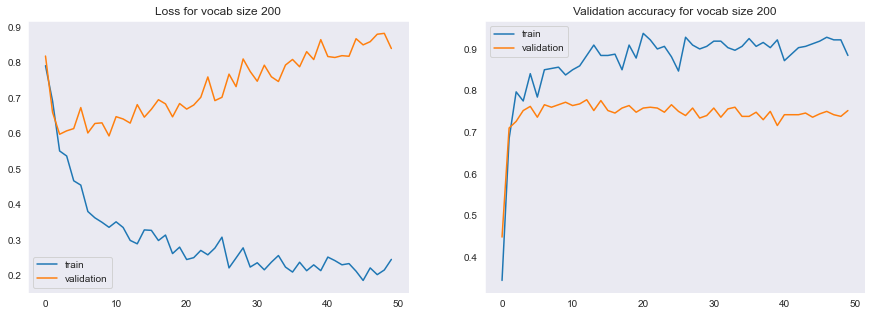

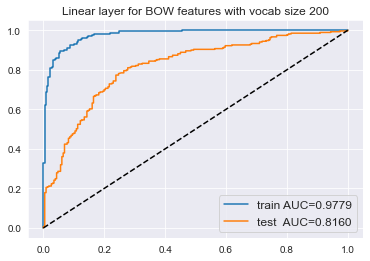

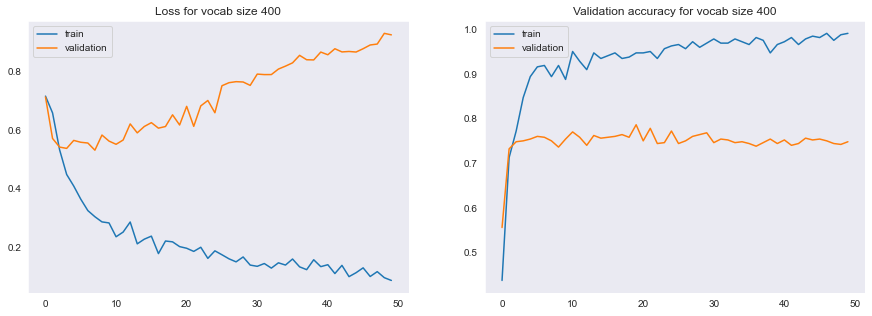

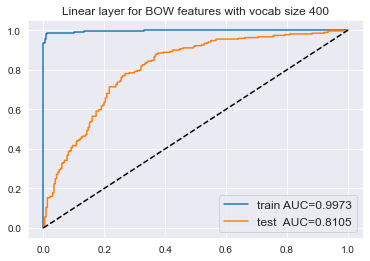

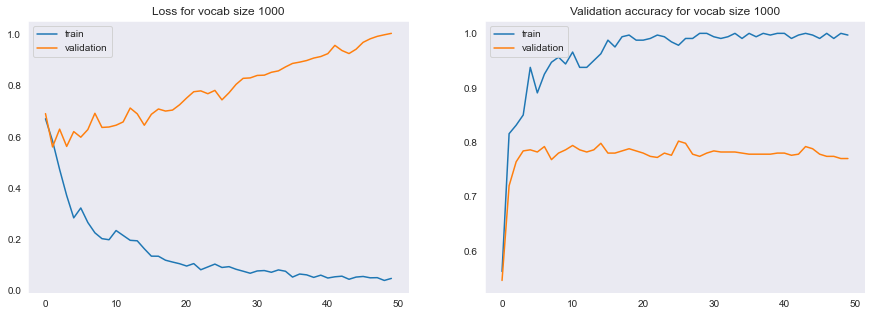

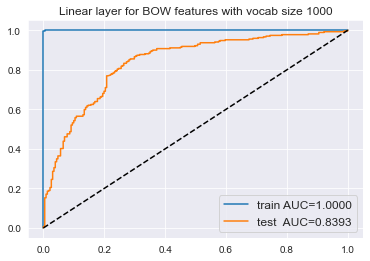

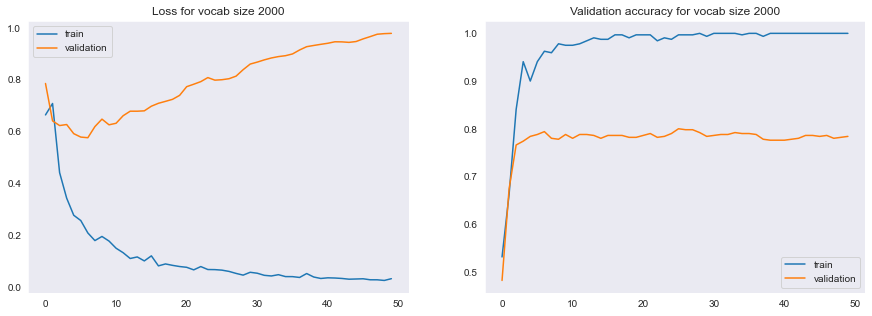

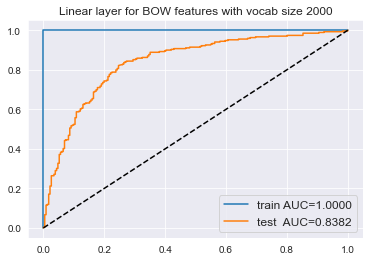

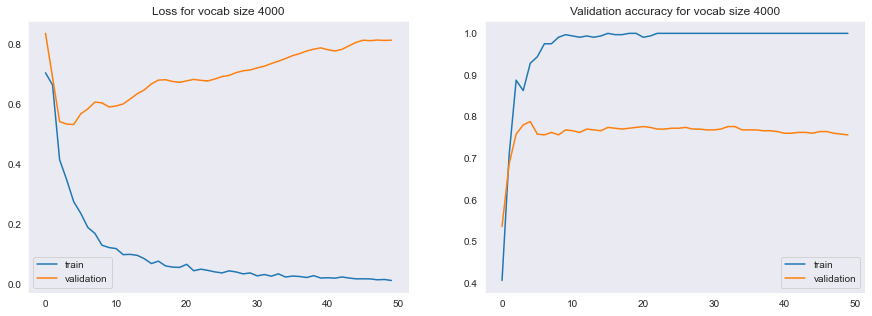

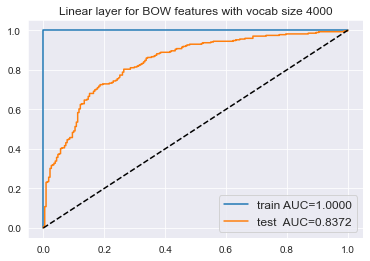

In [28]:
for vocab_size in [200, 400, 1000, 2000, 4000]:
    model, X_train_bow_torch, X_test_bow_torch, y_train_torch, y_test_torch = bow_with_given_vocab_size_learning(vocab_size=vocab_size)
    evaluate_torch_model(model, X_train_bow_torch, y_train, X_test_bow_torch, y_test, f'Linear layer for BOW features with vocab size {vocab_size}')

Well, it's not a surprise that the more vocabulary size we have the more accurate model is. Some inconsistencies in test AUC for vocab_size 2000 and 4000 may be observed, I guess we reach some top possible level of the whole BOW approach in this task.

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [29]:
class SelfMadeTfidf:
    """TF-IDF feature extractor"""
    def __init__(self, corpus: list, alpha=1.0, vocab_size=10000, min_freq=None):
        """Save hyperparams and vocabulary"""
        self._alpha = alpha
        self._vocab_size = min(vocab_size, len(set(' '.join(corpus).split())))
        self._vocab = set([token[0] for token in Counter(' '.join(corpus).split()).most_common()[:self._vocab_size - 1]]) | set({'<UNK>'})
        # self._min_freq = min_freq
        # self._vocab = set(token for token, freq in Counter(' '.join(corpus).split()).items() if freq >= min_freq) | set({'<UNK>'})
        
    def _extract_tf(self, texts):
        """Extract TF features"""
        self._tf = []
        for tokens_list in texts:
            counter_per_text = Counter(tokens_list)
            tf_per_text = {}
            for token in self._vocab:
                tf_per_text[token] = counter_per_text[token] / len(tokens_list)
            tf_per_text['<UNK>'] = sum([cnt for token, cnt in counter_per_text.items() if token not in self._vocab]) / len(tokens_list)
            self._tf.append(tf_per_text)
            
    def _extract_idf(self, texts):
        """Extract IDF features"""
        self._idf = {token: self._alpha for token in self._vocab}
        for tokens_list in texts:
            for token in self._vocab:
                self._idf[token] += int(token in tokens_list)
            self._idf['<UNK>'] += int(len(set(tokens_list) - self._vocab) > 0)
        self._idf = {token: np.log(len(texts) / value) for token, value in self._idf.items()}
        
    def extract(self, texts: list):
        """Extract TF-IDF features for given collection of texts"""
        texts = texts if type(texts[0]) == list else [text.split() for text in texts]
        self._extract_tf(texts)
        self._extract_idf(texts)
        self.features = []
        for tf_per_text in self._tf:
            tfidf = []
            for token, tf_value in tf_per_text.items():
                tfidf.append(tf_value * self._idf[token])
            self.features.append(tfidf)
        self.features = np.array(self.features).astype(np.float32)
        return self.features

Same stuff about model and optimizers here (or just omit it, if you are using the same model as before).

In [30]:
tfidf_vocab_size = 10000
tfidf = SelfMadeTfidf(texts_train)
tfidf_vocab_size = tfidf._vocab_size

X_train_tfidf = tfidf.extract(texts_train)
X_test_tfidf = tfidf.extract(texts_test)

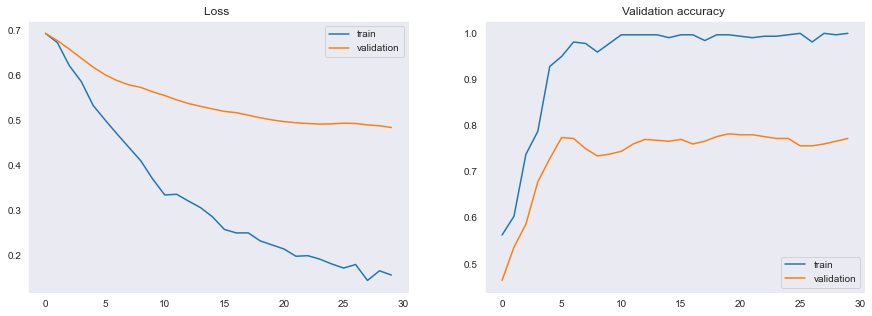

In [31]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf)
X_test_tfidf_torch = torch.tensor(X_test_tfidf)
y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

model_tfidf = nn.Linear(in_features=tfidf_vocab_size, out_features=2)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_tfidf.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)
train_model(model_tfidf, opt, loss_function, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=300);

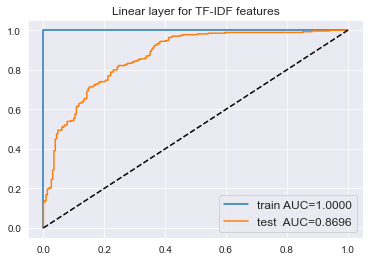

In [32]:
evaluate_torch_model(model_tfidf, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, "Linear layer for TF-IDF features")

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [33]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
mnb_bow = MultinomialNB()
mnb_bow.fit(X_train_bow, y_train)

mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf, y_train)
;

''

In [35]:
def evaluate_naive_bayes(model, X_train, y_train, X_test, y_test, title):
    for name, X, y in [
        ('train', X_train, y_train),
        ('test ', X_test, y_test)
    ]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))
    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.title(title)
    plt.legend(fontsize='large')
    plt.grid()
    plt.show()

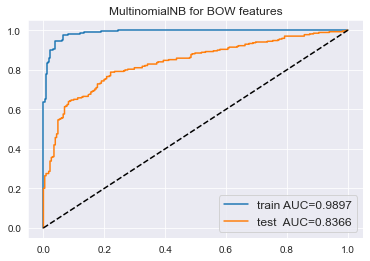

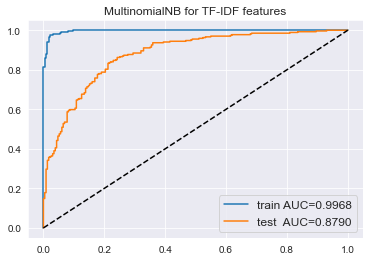

In [36]:
evaluate_naive_bayes(mnb_bow, X_train_bow, y_train, X_test_bow, y_test, 'MultinomialNB for BOW features')
evaluate_naive_bayes(mnb_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, 'MultinomialNB for TF-IDF features')

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

Multinomial Naive Bayes has shown pretty well results, at least it was best among previously fitted Linear Regression and neural networks with one layer. TF-IDF deatures are much more informative rather than BOW features, the results on test adjust this fact.
As for neural network training, I did not observe strong difference when varying learning rate and number of epochs (in some reasonable limits). I guess the dataset is too small to derive influence of changing hyperparams of neural net.

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [9]:
import gensim.downloader as api
list(api.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [10]:
%time twitter25_ = api.load('glove-twitter-25')

Wall time: 1min 19s


In [11]:
%time twitter100_ = api.load('glove-twitter-100')

Wall time: 4min 43s


In [41]:
# twitter100_ = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
# wiki50_ = api.load('glove-wiki-gigaword-50')

In [12]:
class ExternalModel:
    def __init__(self, model, own_vocab=bow_vocabulary, use_unk=True, use_pad=True):
        self._model = model
        self.vocab = {}
        for token in own_vocab:
            try:
                self.vocab[token] = self._model.get_vector(token)
            except KeyError:
                pass
        self.emb_size = self._model.vector_size
        if use_unk:
            self.vocab['<UNK>'] = np.zeros((self.emb_size))
        if use_pad:
            self.vocab['<PAD>'] = np.zeros((self.emb_size))
        
    def __getitem__(self, token):
        return self.vocab[token]

In [13]:
twitter25 = ExternalModel(twitter25_)
twitter100 = ExternalModel(twitter100_)

In [18]:
def get_phrase_embedding(phrase, ext_model):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # assume phrase was preprocessed
    # average word vectors for all words in tokenized phrase
    
    vector = np.zeros([ext_model.emb_size], dtype='float32')
    phrase_vectors = [ext_model[token] for token in phrase.split() if token in ext_model.vocab.keys()]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)
    return vector

def phrase_embeddings_for_train_test(texts_train, texts_test, ext_model):
    emb_getter = lambda phrase: get_phrase_embedding(phrase, ext_model)
    X_train = np.stack(list(map(emb_getter, texts_train)))
    X_test = np.stack(list(map(emb_getter, texts_test)))
    return X_train, X_test

In [47]:
# check that evrything is OK
assert get_phrase_embedding('i love texts', twitter25).shape[0] == 25
assert get_phrase_embedding('natural language processing', twitter100).shape[0] == 100

In [48]:
X_train_phrase_emb_25, X_test_phrase_emb_25 = phrase_embeddings_for_train_test(texts_train, texts_test, twitter25)
X_train_phrase_emb_100, X_test_phrase_emb_100 = phrase_embeddings_for_train_test(texts_train, texts_test, twitter100)

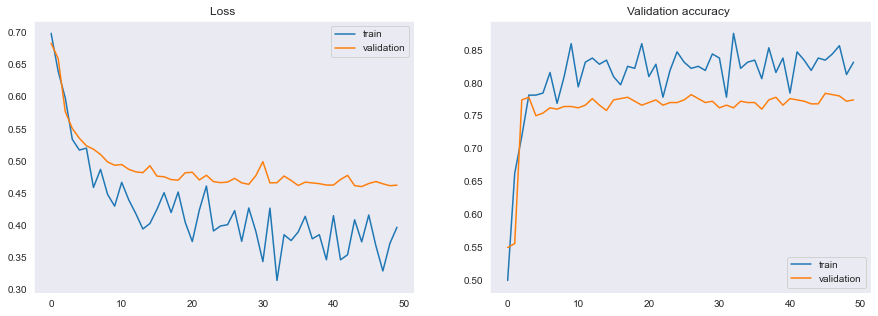

Linear(in_features=25, out_features=2, bias=True)

In [50]:
X_train_phrase_emb_torch_25 = torch.tensor(X_train_phrase_emb_25)
X_test_phrase_emb_torch_25 = torch.tensor(X_test_phrase_emb_25)
y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

model_phrase_emb_25 = nn.Linear(in_features=twitter25.emb_size, out_features=2)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_phrase_emb_25.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)
train_model(model_phrase_emb_25, opt, loss_function, lr_scheduler, X_train_phrase_emb_torch_25, y_train_torch, X_test_phrase_emb_torch_25, y_test_torch, n_iterations=500)

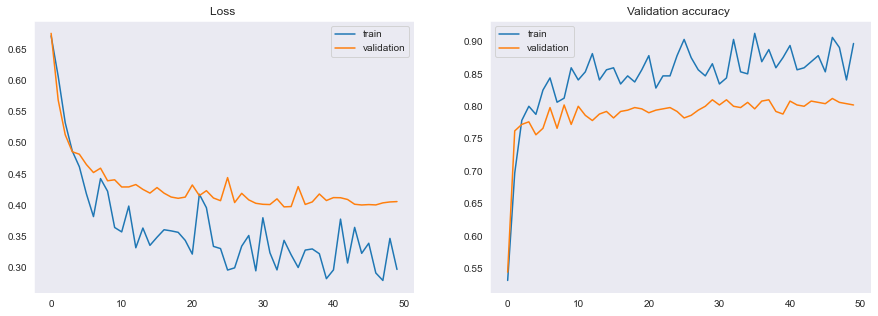

Linear(in_features=100, out_features=2, bias=True)

In [51]:
X_train_phrase_emb_torch_100 = torch.tensor(X_train_phrase_emb_100)
X_test_phrase_emb_torch_100 = torch.tensor(X_test_phrase_emb_100)
y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

model_phrase_emb_100 = nn.Linear(in_features=twitter100.emb_size, out_features=2)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_phrase_emb_100.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)
train_model(model_phrase_emb_100, opt, loss_function, lr_scheduler, X_train_phrase_emb_torch_100, y_train_torch, X_test_phrase_emb_torch_100, y_test_torch, n_iterations=500)

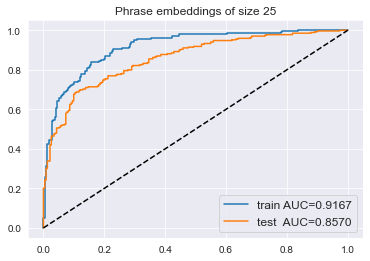

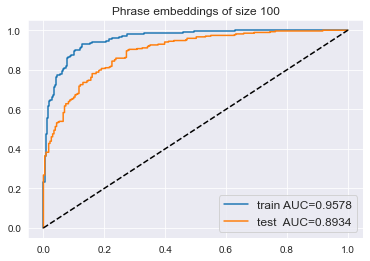

In [52]:
evaluate_torch_model(model_phrase_emb_25, X_train_phrase_emb_torch_25, y_train_torch, X_test_phrase_emb_torch_25, y_test_torch, 
                     f'Phrase embeddings of size {twitter25.emb_size}')
evaluate_torch_model(model_phrase_emb_100, X_train_phrase_emb_torch_100, y_train_torch, X_test_phrase_emb_torch_100, y_test_torch, 
                     f'Phrase embeddings of size {twitter100.emb_size}')

As we see, embeddings with larger size are more informative and let us achieve higher test AUC value.

In [36]:
phrases = ['i like map', 'my state university', 'made shot like selfie', 'hello hello suka you are from streets like getto', 'shit face what you dance']
max(map(lambda text: len(text.split()), phrases))

9

In [39]:
be = batch_phrase_embedding_by_concat(phrases, twitter25)

be.shape

torch.Size([5, 25, 9])

In [116]:
conv = nn.Conv1d(in_channels=25, out_channels=50, kernel_size=2)

In [118]:
res = conv(be)

In [119]:
res.shape

torch.Size([5, 50, 8])

In [121]:
pool = nn.AdaptiveMaxPool1d(output_size=2)
ad = pool(res)
ad.shape

torch.Size([5, 50, 2])

In [124]:
flat = nn.Flatten()
fl = flat(ad)
fl.shape

torch.Size([5, 100])

In [38]:
def batch_phrase_embedding_by_concat(phrases, ext_model, max_len=None):
    phrases = phrases if isinstance(phrases[0], list) else [phrase.split() for phrase in phrases]
    max_len = min(max(map(len, phrases)), max_len or float('inf'))
    embeddings = torch.stack([torch.from_numpy(phrase_embedding_by_concat(phrase, ext_model, max_len)) for phrase in phrases]).float()
    return embeddings
    

def phrase_embedding_by_concat(tokens, ext_model, max_len=None):
    """
    get phrase embeddings via concatting word embeddings
    output size: (emb_size, len(phrase))
    """
#     tokens = phrase.split()
    max_len = max(len(tokens), max_len or -float('inf'))
    phrase_vectors = [ext_model[tokens[i]] if (i < len(tokens) and tokens[i] in ext_model.vocab.keys()) else ext_model['<PAD>'] for i in range(max_len)]
    return np.array(phrase_vectors).T

In [113]:
class ConvTextNetwork(nn.Module):
    def __init__(self, emb_size, maxpool_size=2):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=emb_size, out_channels=2*emb_size, kernel_size=2)
        self.act = nn.ReLU()
#         self.bnorm = nn.BatchNorm1d(2*emb_size)
        self.pool = nn.AdaptiveMaxPool1d(output_size=maxpool_size)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(2*emb_size*maxpool_size, 2)
    
    def forward(self, x):
        x = self.conv(x)
#         x = self.bnorm(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


class ConvTextNetwork2(nn.Module):
    def __init__(self, emb_size, maxpool_size=2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=emb_size, out_channels=2*emb_size, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=2*emb_size, out_channels=2*emb_size, kernel_size=2)
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(output_size=maxpool_size)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(2*emb_size*maxpool_size, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

In [77]:
# improve train and validation (split on batches, sort them by size (to not add many pad tokens for phrases of different size))

In [82]:
def train_conv_text_net(
    model, opt, loss_function, lr_scheduler, ext_model,
    texts_train, y_train, texts_test, y_test,
    n_iterations=500,
    batch_size=8,
    show_plots=True,
    show_final_plot=False,
    eval_every=10,
    title_suffix=''
):
    texts_train = texts_train if isinstance(texts_train[0], list) else [text.split() for text in texts_train]
#     texts_test = texts_test if isinstance(texts_test[0], list) else [text.split() for text in texts_test]
    texts_train, y_train = zip(*sorted(zip(texts_train, y_train), key=lambda pair: len(pair[0])))
#     texts_test, y_test = zip(*sorted(zip(texts_test, y_test), , key=lambda pair: len(pair[0])))
    
    y_train = torch.tensor(y_train)
    y_val = torch.tensor(y_test)
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size observations
        # i sort texts beforehand so that sampling would return texts of similar [close] size
        # this is done to avoid overuse of padding in texts when their lengths differ
        ix = np.cumsum(np.random.choice([0, 1], size=batch_size, p=[0.7, 0.3]) + np.ones(batch_size))
        ix = ix + np.random.randint(0, len(texts_train) - max(ix))
        ix = ix.astype(int)
        texts_batch = [texts_train[i] for i in ix]
        
        x_batch = batch_phrase_embedding_by_concat(texts_batch, ext_model)
        y_batch = y_train[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)
        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)
        # compute gradients
        loss.backward()
        # Adam step
        opt.step()
        # clear gradients
        opt.zero_grad()

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []
            
            local_val_loss_history, local_val_acc_history = [], []
            for text, y_single_val in zip(texts_test, y_val):
                x_single_val = batch_phrase_embedding_by_concat([text], ext_model)
                y_single_val = y_single_val.unsqueeze(dim=0)
                predictions_val = model(x_single_val)
                local_val_loss_history.append(loss_function(predictions_val, y_single_val).to('cpu').detach().item())
                acc_score_val = accuracy_score(y_single_val.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
                local_val_acc_history.append(acc_score_val)
            
            val_loss_history.append(np.mean(local_val_loss_history))
            val_acc_history.append(np.mean(local_val_acc_history))
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history, title_suffix=title_suffix)
    if show_final_plot:
        plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history, title_suffix=title_suffix)
    return model

In [111]:
def evaluate_conv_text_net(model, ext_model, texts_train, y_train, texts_test, y_test, title):
    for name, texts, y in [
        ('train', texts_train, y_train),
        ('test ', texts_test, y_test)
    ]:
        proba = np.array([], dtype=np.float32)
        for text in texts:
            proba_single = model(batch_phrase_embedding_by_concat([text], ext_model)).detach().cpu().numpy()[:, 1]
            proba = np.append(proba, proba_single)
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))
    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.title(title)
    plt.legend(fontsize='large')
    plt.grid()
    plt.show()

In [100]:
ctnet_25 = ConvTextNetwork(twitter25.emb_size)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(ctnet_25.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

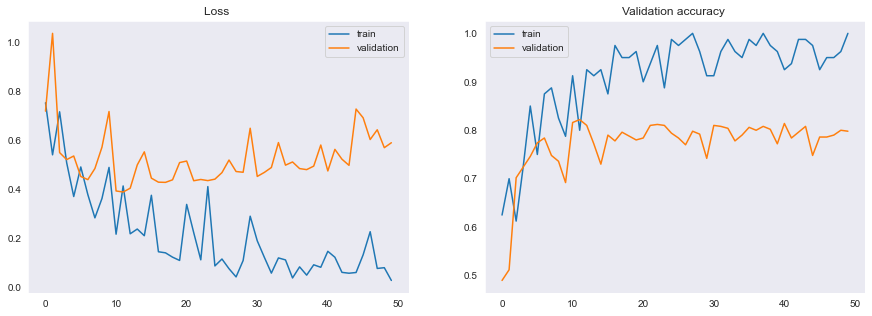

ConvTextNetwork(
  (conv): Conv1d(25, 50, kernel_size=(2,), stride=(1,))
  (act): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=2)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [83]:
train_conv_text_net(
    ctnet_25, opt, loss_function, lr_scheduler, twitter25,
    texts_train, y_train, texts_test, y_test,
)

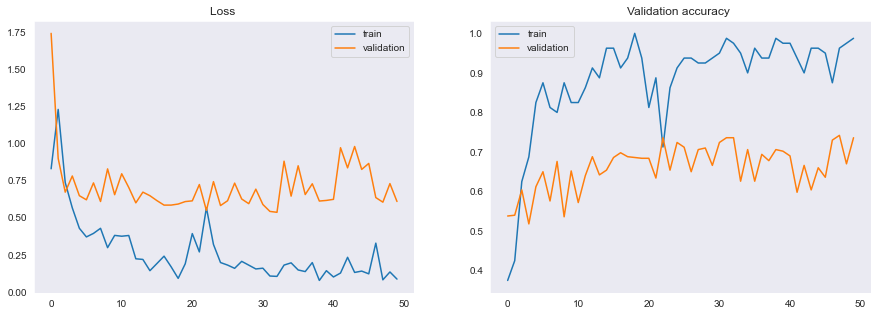

ConvTextNetwork(
  (conv): Conv1d(25, 50, kernel_size=(2,), stride=(1,))
  (act): ReLU()
  (bnorm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveMaxPool1d(output_size=2)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [101]:
train_conv_text_net(
    ctnet, opt, loss_function, lr_scheduler, twitter25,
    texts_train, y_train, texts_test, y_test,
)

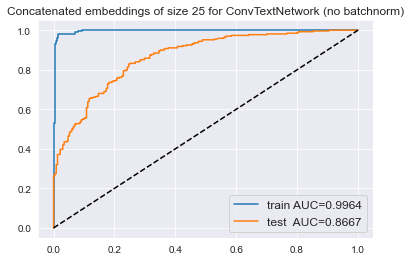

In [98]:
evaluate_conv_text_net(ctnet, twitter25, texts_train, y_train, texts_test, y_test, 
                       f'Concatenated embeddings of size {twitter25.emb_size} for ConvTextNetwork (no batchnorm)')

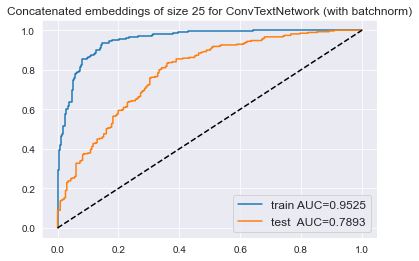

In [102]:
evaluate_conv_text_net(ctnet, twitter25, texts_train, y_train, texts_test, y_test, 
                       f'Concatenated embeddings of size {twitter25.emb_size} for ConvTextNetwork (with batchnorm)')

In [105]:
ctnet_100 = ConvTextNetwork(twitter100.emb_size)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(ctnet_100.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

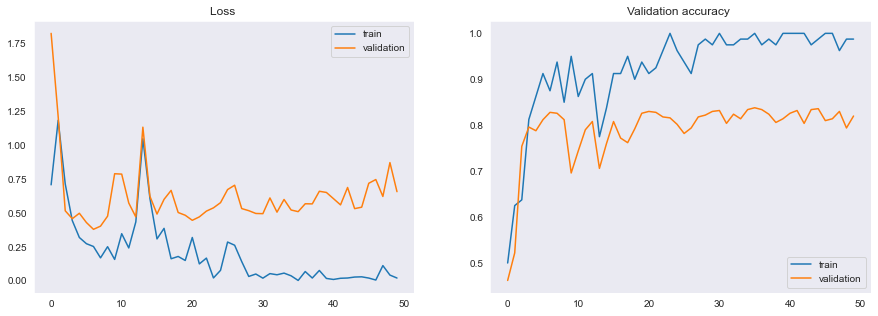

ConvTextNetwork(
  (conv): Conv1d(100, 200, kernel_size=(2,), stride=(1,))
  (act): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=2)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=400, out_features=2, bias=True)
)

In [106]:
train_conv_text_net(
    ctnet_100, opt, loss_function, lr_scheduler, twitter100,
    texts_train, y_train, texts_test, y_test,
)

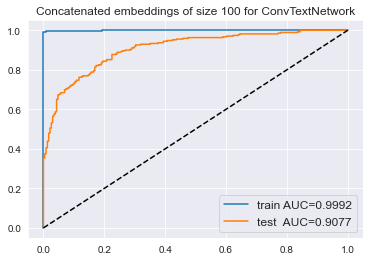

In [112]:
evaluate_conv_text_net(ctnet_100, twitter100, texts_train, y_train, texts_test, y_test, 
                       f'Concatenated embeddings of size {twitter100.emb_size} for ConvTextNetwork')

In [130]:
ctnet_2_100 = ConvTextNetwork(twitter100.emb_size)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(ctnet_2_100.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

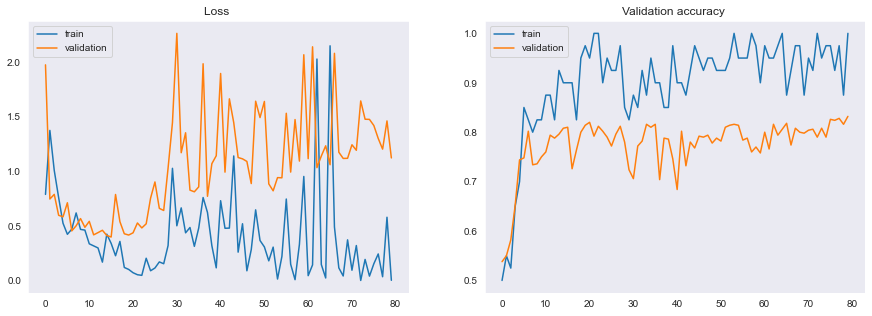

ConvTextNetwork(
  (conv): Conv1d(100, 200, kernel_size=(2,), stride=(1,))
  (act): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=2)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=400, out_features=2, bias=True)
)

In [120]:
train_conv_text_net(
    ctnet_2_100, opt, loss_function, lr_scheduler, twitter100,
    texts_train, y_train, texts_test, y_test, batch_size=4, n_iterations=800
)

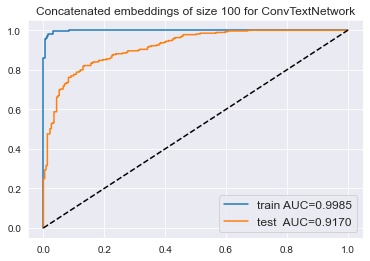

In [122]:
evaluate_conv_text_net(ctnet_2_100, twitter100, texts_train, y_train, texts_test, y_test, 
                       f'Concatenated embeddings of size {twitter100.emb_size} for ConvTextNetwork')

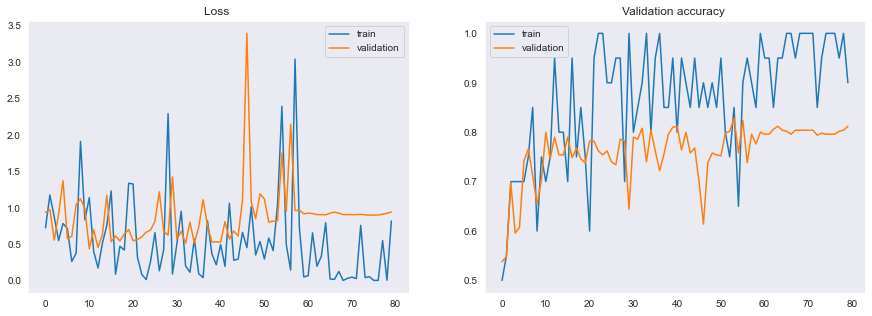

ConvTextNetwork(
  (conv): Conv1d(100, 200, kernel_size=(2,), stride=(1,))
  (act): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=2)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=400, out_features=2, bias=True)
)

In [131]:
train_conv_text_net(
    ctnet_2_100, opt, loss_function, lr_scheduler, twitter100,
    texts_train, y_train, texts_test, y_test, batch_size=2, n_iterations=800
)

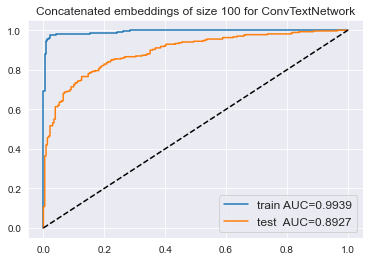

In [133]:
evaluate_conv_text_net(ctnet_2_100, twitter100, texts_train, y_train, texts_test, y_test, 
                       f'Concatenated embeddings of size {twitter100.emb_size} for ConvTextNetwork')